# Prvi domaći zadatak iz predmeta 13E044DOS - Digitalna obrada slike
<hr>
<p style="font-size:20px">Viktor Todosijević 0050/2017</p>

## Prvi zadatak
<hr>

Automatsko numerisanje jednačina

In [110]:
%%javascript
MathJax.Hub.Config({
    TeX: { equationNumbers: { autoNumber: "AMS" } }
});

<IPython.core.display.Javascript object>

In [111]:
import numpy as np
import imageio
from matplotlib import pyplot as plt
import ipywidgets as widgets

%matplotlib inline

from IPython.display import display, HTML

display(HTML("""
<style>
.output {
    display: flex;
    align-items: center;
    text-align: center;
}
</style>
"""))


### Učitavanje

In [112]:
imageio.plugins.freeimage.download()
img = imageio.imread('sekvence/sea.hdr',
                     format='HDR-FI')

### Rekreiranje slika sa gubicima u procentima

In [113]:
loss = [0, 0.001, 0.01]  # od 1
img_sat_array = {}  # dictionary
for i in range(len(loss)):
    img_sat_array[loss[i]] = np.array(img)  
    img_sat_array[loss[i]] /= np.amax(img_sat_array[loss[i]])
    
    img_flat_sort = img_sat_array[loss[i]].flatten()
    img_flat_sort.sort()  # trazimo zacrtani procenat

Sada kada smo sortirali niz možemo da zasitimo određeni procenat najvećih.

In [114]:
    index = round(-img_sat_array[loss[i]].size * loss[i] - 1)  # minus 1 zbog nule, da bi uzeo sa kraja a ne sa pocetka
    sat_max = img_flat_sort[np.int(index)]  # maks vrednost na osnovu gubitka
    img_sat_array[loss[i]][img_sat_array[loss[i]] > sat_max] = sat_max
    img_sat_array[loss[i]] = img_sat_array[loss[i]] / sat_max

Izvršimo gama korekciju.

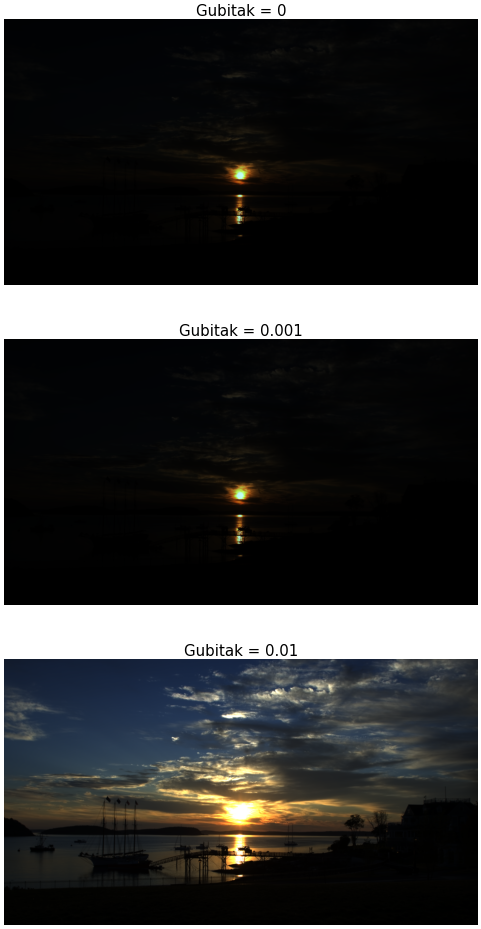

In [115]:
fig, ax = plt.subplots(3, 1, figsize=(60,30), dpi=40);
gamma = 1.0

fontsize = 27
for i, chosen_loss in enumerate(loss):
    chosen_img = img_sat_array[chosen_loss]
    gamma_img = chosen_img ** (1/gamma)
    
    ax[i].imshow(gamma_img, vmin=np.amin(gamma_img), vmax=np.amax(gamma_img))
    ax[i].set_title("Gubitak = " + str(chosen_loss), fontsize=fontsize)
    ax[i].axis('off')


### A) Interaktivno traženje pojačanja A, B i C
Ispod je postojao slajder ali se u PDF-u izgubio.

In [116]:
# Interaktivno trazenje pojacanja
img_0_1 = img_sat_array[0]

In [117]:
def linear_map(A):
    
    # linearno skaliramo sliku pa izvršimo gama korekciju
    gamma = 2.2
    img_scaled = A * img_0_1
    gamma_img = img_scaled ** (1/gamma)
    gamma_img_clipped = np.clip(gamma_img, 0, 1)
    
    fig = plt.figure(figsize = (8, 6))
    plt.imshow(gamma_img_clipped)
    plt.title("Pojacanje = " + '%.2f' % A)
    plt.show()

In [118]:
widgets.interact(linear_map, A=widgets.FloatLogSlider(
    value=10,
    base=10,
    min=0, # max exponent of base
    max=2, # min exponent of base
    step=0.02, # exponent step
    ));

interactive(children=(FloatLogSlider(value=10.0, description='A', max=2.0, step=0.02), Output()), _dom_classes…

#### Rezultati linearnog skaliranja

In [119]:
A = 2.5 # mada moze biti +- 0.75
B = 17.5
C = 38
gain = [A, B, C]
gain_char = ["A", "B", "C"]

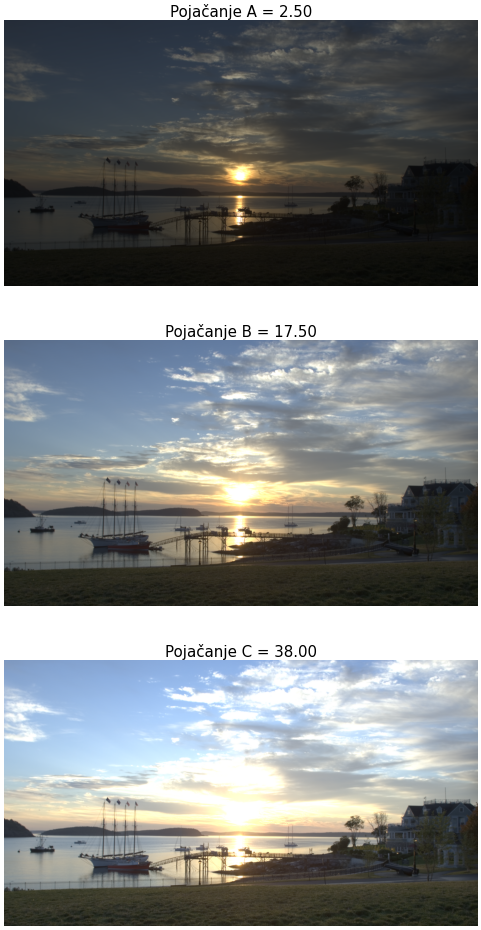

In [120]:
fig, ax = plt.subplots(3, 1, figsize=(60,30), dpi=40);
img_0_1 = img_sat_array[0]
gamma = 2.2

for i in range(len(gain)):
    img_scaled = gain[i] * img_0_1
    gamma_img = img_scaled ** (1/gamma)
    gamma_img_clipped = np.clip(gamma_img, 0, 1)
    
    ax[i].imshow(gamma_img_clipped, vmin=np.amin(gamma_img), vmax=np.amax(gamma_img))
    ax[i].set_title("Pojačanje " + gain_char[i] + " = " + "%.2f" % gain[i], fontsize=fontsize)
    ax[i].axis('off')



### B) Transformacija logaritamskom i stepenom funkcijom

#### Logaritamska transformacija
\begin{equation}
y=c*log_b(1 + kx)
\end{equation}

\begin{equation}
c = \displaystyle\frac{1}{log_b(1 + k)}
\end{equation}


In [121]:
def log_base(base, x):
    return np.log(x) / np.log(base)

# c*log_b(1 + k*x)
# c*log_b(1 + k*1) = 1
# c = 1/log_b(1 + k)

base = 2 # base je zapravo nepotrebno jer imamo log_base(1 + kx) / log_base(1 + k) = log_1+k (1 + kx)
k = 100
c = 1 / log_base(base, 1 + k)
t = np.linspace(0, 1, 100)

#### Stepena transformacija
\begin{equation}
y = x^p
\end{equation}

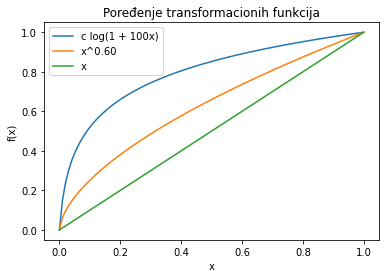

In [122]:
power = 0.6
plt.plot(t, c*log_base(base, 1 + k*t), label="c log(1 + " + "%d" % k + "x)")
plt.plot(t,t**power, label="x^" + "%.2f" % power)
plt.plot(t, t, label="x")

plt.title("Poređenje transformacionih funkcija")
plt.xlabel("x")
plt.ylabel("f(x)")
plt.legend()
plt.show()
    

Kao što se sa grafika može videti, obe transformacije daju više prostora na y osi pikselima sa manjim intenzitetom.

In [123]:
def log_scale(base, k, img, gamma):
    c = 1 / log_base(base, 1 + k)
    
    log_img = c*log_base(base, 1 + k*img)
    log_img_gamma = log_img **(1/gamma)
    return np.clip(log_img_gamma, 0, 1)

def power_scale(power, img, gamma):
    pow_img = img**power
    pow_img_gamma = pow_img**(1/gamma)
    return np.clip(pow_img_gamma, 0, 1)

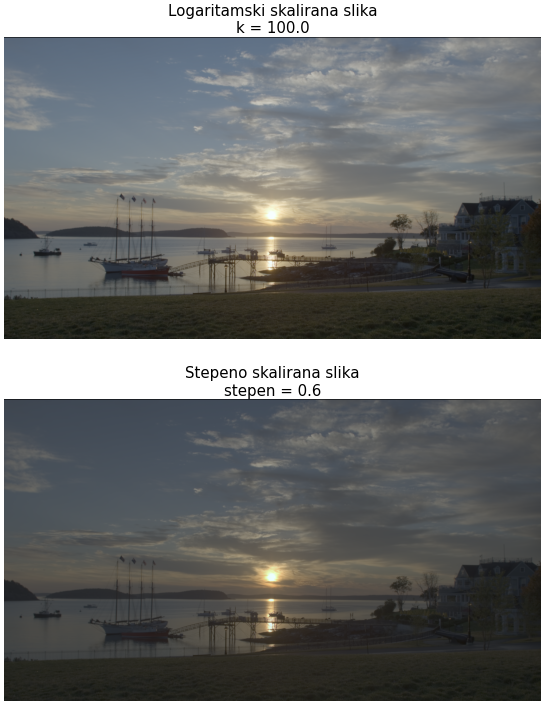

In [124]:
img_0_1 = img_sat_array[0]
gamma = 2.2
log_scaled_img = log_scale(base, k, img_0_1, gamma)
power_scaled_img = power_scale(power, img_0_1, gamma)

fig, ax = plt.subplots(2, 1, figsize=(32,22), dpi=40);

ax[0].imshow(log_scaled_img)
ax[0].set_title("Logaritamski skalirana slika\nk = " + "%.1f" % k, fontsize=fontsize)
ax[0].axis('off')

ax[1].imshow(power_scaled_img)
ax[1].set_title("Stepeno skalirana slika\nstepen = " + "%.1f" % power, fontsize=fontsize)
ax[1].axis('off')
plt.show()

### C) Neko drugo mapiranje
Ideja je da uradimo logaritamsku transformaciju pa da linearnim skaliranjem zasitimo najsvetlije piksele. Slika jeste malo svetlija ali ciljao sam da se vidi travnjak. Ako je fokus izlazak sunca onda ovo nije pravi izbor.

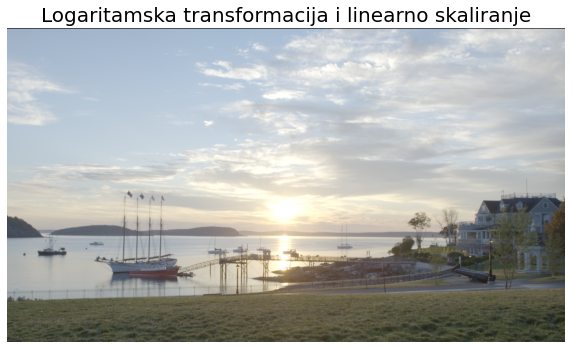

In [125]:
img_0_1 = img_sat_array[0]
k = 400
base = 2
gamma = 2.2


gain1 = 1.3
img_scaled_log = gain1 * log_scale(base, k, img_0_1, gamma)
clipped_img = np.clip(img_scaled_log, 0, 1)

plt.figure(figsize=(10,10))
plt.imshow(clipped_img)
plt.title("Logaritamska transformacija i linearno skaliranje", fontsize=20)
plt.axis('off')
plt.show()

Apdejtovanje numerisanja jednačina

In [126]:
%%javascript
MathJax.Hub.Queue(
  ["resetEquationNumbers", MathJax.InputJax.TeX],
  ["PreProcess", MathJax.Hub],
  ["Reprocess", MathJax.Hub]
);

<IPython.core.display.Javascript object>